In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Modelos y Métricas
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, roc_auc_score, RocCurveDisplay,
                             ConfusionMatrixDisplay, precision_score, recall_score,
                             f1_score, confusion_matrix)

# Balanceo (si lo usas, si no, puedes quitarlo)
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [2]:
MODELOCL = 'CL'
MODELOAR = 'DOMAR'
MODELOPE = 'DOMPE'
MODELOCO = 'DOMCO'
MODELOIN = 'INTER'

In [3]:
# CONFIGURACIÓN
SEED = 42
pd.set_option('display.max_columns', None)

# Umbral de decisión (Ajustable: > 0.5 para más precisión, < 0.5 para más recall)
UMBRAL_CORTE = 0.5

# RUTA A LA CARPETA DE DATOS
DATA_DIR = 'Data/'

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
PARAMS_LR_GENERAL = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C':0.4914, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

PARAMS_LR_CHILE = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C': 0.4618, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

PARAMS_LR_ARGENTINA = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C': 0.5140, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

PARAMS_LR_COLOMBIA = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C': 0.5334, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

PARAMS_LR_PERU = {
    'solver': 'saga', 'l1_ratio': 1.0,
    'C': 0.5157, 'class_weight': None, 'random_state': SEED,
    'usar_smote': True, 'max_iter': 5000
}

MAPA_PARAMETROS = {
    'General': PARAMS_LR_GENERAL,
    'CL': PARAMS_LR_CHILE,
    'AR': PARAMS_LR_ARGENTINA,
    'CO': PARAMS_LR_COLOMBIA,
    'PE': PARAMS_LR_PERU
}

In [5]:
def entrenar_modelo_visual(X_train, X_test, y_train, y_test, nombre_modelo, params, top_n_importance=15):
    print(f" PROCESANDO MODELO: {nombre_modelo}")

    sk_params = {k: v for k, v in params.items() if k != 'usar_smote'}

    pasos = [
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(**sk_params))
    ]
    pipeline = Pipeline(pasos)

    # 1. SMOTE
    if params.get('usar_smote', False):
        print(f"-> Aplicando SMOTE en {nombre_modelo}...")
        smote = SMOTE(random_state=SEED)
        X_train_final, y_train_final = smote.fit_resample(X_train, y_train)
    else:
        X_train_final, y_train_final = X_train, y_train

    # 2. Pipeline (Escalado + Modelo)


    print("-> Entrenando Regresión Logística (con Escalado estándar)...")
    pipeline.fit(X_train_final, y_train_final)

    # Extraemos el modelo real SOLO para los coeficientes, NO para predecir
    model_trained = pipeline.named_steps['model']

    # 3. Predicciones (Usando el PIPELINE completo para que escale X_test)
    probs = pipeline.predict_proba(X_test)[:, 1]
    preds = (probs > UMBRAL_CORTE).astype(int)

    # Métricas
    auc = roc_auc_score(y_test, probs)
    precision_1 = precision_score(y_test, preds, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, preds, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, preds, pos_label=1, zero_division=0)

    precision_0 = precision_score(y_test, preds, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, preds, pos_label=0, zero_division=0)
    f1_0 = f1_score(y_test, preds, pos_label=0, zero_division=0)

    print(f"\n--- RESULTADOS: {nombre_modelo} ---")
    print(f"ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, preds, target_names=['Ocio (0)', 'Trabajo (1)']))

    metrics = {
        'ROC-AUC': auc,
        'Precision_1': precision_1, 'Recall_1': recall_1, 'F1-Score_1': f1_1,
        'Precision_0': precision_0, 'Recall_0': recall_0, 'F1-Score_0': f1_0
    }

    # 4. Gráficos: Matriz y ROC
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ocio', 'Trabajo'])
    disp.plot(ax=ax[0], cmap='Blues', values_format='d')
    ax[0].set_title(f"Matriz de Confusión (Umbral {UMBRAL_CORTE})")
    ax[0].grid(False)

    # ROC - usar pipeline para escalar antes de evaluar
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax[1], name=nombre_modelo)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_title(f'Curva ROC - {nombre_modelo}')

    plt.tight_layout()
    plt.show()

    # 5. Gráfica de importancia de features (coeficientes / odds ratio)
    try:
        if hasattr(model_trained, 'coef_'):
            # obtener nombres de features
            if isinstance(X_train, pd.DataFrame):
                feat_names = X_train.columns.tolist()
            else:
                feat_names = [f"f_{i}" for i in range(X_train.shape[1])]

            coefs = model_trained.coef_.ravel()
            n = min(len(coefs), len(feat_names))
            coefs = coefs[:n]
            feat_names = feat_names[:n]

            df_imp = pd.DataFrame({
                'feature': feat_names,
                'coef': coefs,
                'odds_ratio': np.exp(coefs),
                'abs_impact': np.abs(coefs)
            }).sort_values('abs_impact', ascending=False).head(top_n_importance)

            # Plot horizontal bar
            fig2, ax2 = plt.subplots(figsize=(10, max(4, 0.4 * len(df_imp))))
            df_plot = df_imp[::-1]  # invertir para que la más importante esté arriba
            colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in df_plot['coef']]
            bars = ax2.barh(df_plot['feature'], df_plot['coef'], color=colors)
            ax2.set_xlabel('Coeficiente (impacto en variable estandarizada)')
            ax2.set_title(f'Importancia de features - {nombre_modelo} (top {len(df_plot)})')
            ax2.axvline(0, color='black', linestyle='--', linewidth=0.8)

            # anotar valores en las barras
            try:
                ax2.bar_label(bars, fmt='%.3f', padding=6)
            except Exception:
                x_off = df_plot['coef'].abs().max() * 0.01 if len(df_plot) else 0.01
                for bar in bars:
                    w = bar.get_width()
                    ax2.text(w + x_off, bar.get_y() + bar.get_height() / 2, f'{w:.3f}', va='center', ha='left', fontsize=9)

            plt.tight_layout()
            plt.show()
        else:
            print("Aviso: el estimador no tiene atributo `coef_`, no se puede graficar importancia.")
    except Exception as e:
        print("No se pudo generar la gráfica de importancia:", e)

    # Retornamos model_trained para ver coeficientes, y metrics para tabla
    return model_trained, metrics

In [6]:
def graficar_importancia_features(model_trained, nombre_modelo, feature_names, top_n=15):
    # 1. Extraer coeficientes y calcular Odds Ratio
    coefs = model_trained.coef_[0]

    df_importancia = pd.DataFrame({
        'feature': feature_names,
        'coef': coefs,
        'odds_ratio': np.exp(coefs), # La métrica clave en Logística
        'abs_impact': np.abs(coefs)  # Para ordenar visualmente
    }).sort_values('abs_impact', ascending=False).head(top_n)

    # 2. Graficar
    plt.figure(figsize=(10, 8))
    # Colores: Verde si aumenta probabilidad de Trabajo (coef > 0), Rojo si es Ocio
    colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in df_importancia['coef']]




In [7]:
def matriz_correlacion_por_modelo(model_or_pipeline, X, feature_names=None, top_n=None,
                                  method='pearson', figsize=(24,12), cmap='coolwarm'):
    # 1. Preparar datos en DataFrame y nombres de features
    if isinstance(X, pd.DataFrame):
        df_X = X.copy()
    else:
        # X es array; requerimos feature_names
        if feature_names is None:
            # generar nombres genéricos
            feature_names = [f"f_{i}" for i in range(X.shape[1])]
        df_X = pd.DataFrame(X, columns=feature_names)

    # 2. Si nos pasan un Pipeline y tiene scaler, aplicarlo (opcional)
    model = model_or_pipeline
    if isinstance(model_or_pipeline, Pipeline):
        # intentar extraer modelo final y scaler
        if 'scaler' in model_or_pipeline.named_steps:
            scaler = model_or_pipeline.named_steps['scaler']
            try:
                X_scaled = scaler.transform(df_X)
                df_X = pd.DataFrame(X_scaled, columns=df_X.columns)
            except Exception:
                # si falla, dejamos df_X sin escalar
                pass
        # intentar obtener el estimador final si existe (para coeficientes)
        model = model_or_pipeline.named_steps.get('model', model_or_pipeline)

    # 3. Selección de top_n features usando coeficientes si se pide
    if top_n is not None and hasattr(model, 'coef_'):
        coefs = np.ravel(model.coef_)
        if len(coefs) != df_X.shape[1]:
            print(f"WARNING: mismatch entre coef ({len(coefs)}) y features ({df_X.shape[1]}). Usando intersección por posición.")
            n = min(len(coefs), df_X.shape[1])
            coefs = coefs[:n]
            df_X = df_X.iloc[:, :n]

        # seleccionar top_n por impacto absoluto
        abs_idx = np.argsort(np.abs(coefs))[::-1][:top_n]
        selected_cols = [df_X.columns[i] for i in abs_idx]
        df_sel = df_X[selected_cols]
    else:
        df_sel = df_X.copy()

    # 4. Calcular matriz de correlación
    corr = df_sel.corr(method=method)

    # 5. Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1,
                square=True, cbar_kws={'shrink': .8})
    plt.title(f"Matriz de correlación ({method}) - {('top_'+str(top_n)) if top_n else 'todas las features'}")
    plt.tight_layout()
    plt.show()

    return corr

Cargando datos para el Modelo General...
 PROCESANDO MODELO: General
-> Aplicando SMOTE en General...
-> Entrenando Regresión Logística (con Escalado estándar)...

--- RESULTADOS: General ---
ROC-AUC: 0.7646
              precision    recall  f1-score   support

    Ocio (0)       0.86      0.71      0.78      4551
 Trabajo (1)       0.44      0.67      0.53      1540

    accuracy                           0.70      6091
   macro avg       0.65      0.69      0.66      6091
weighted avg       0.76      0.70      0.72      6091



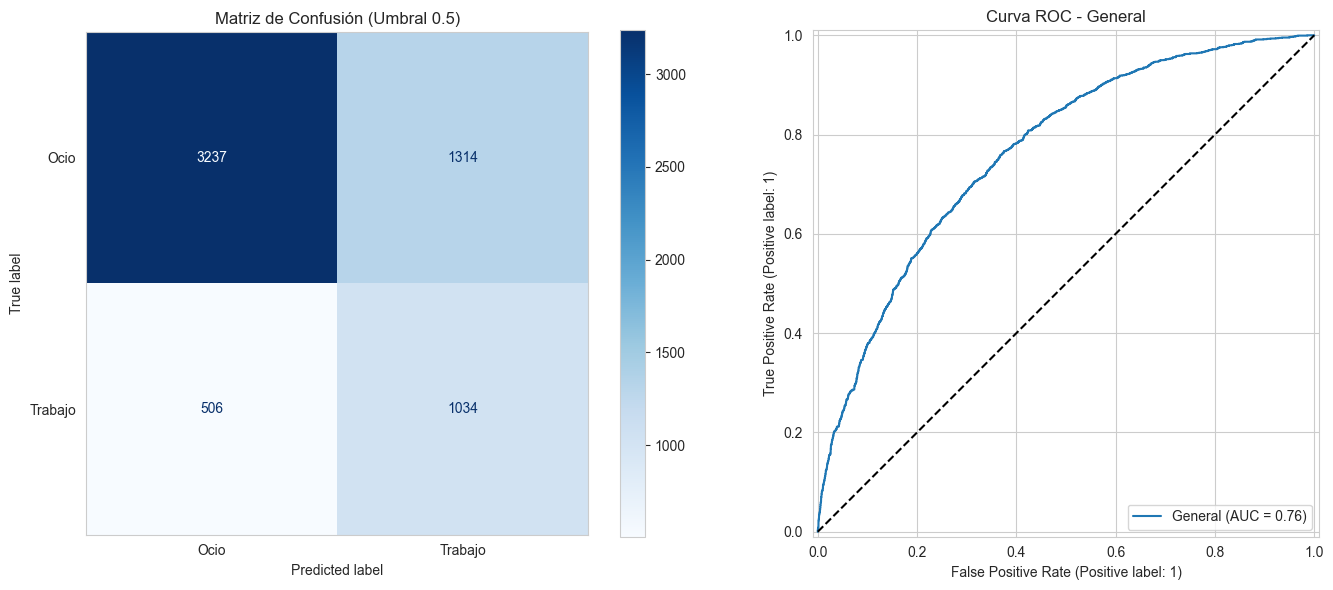

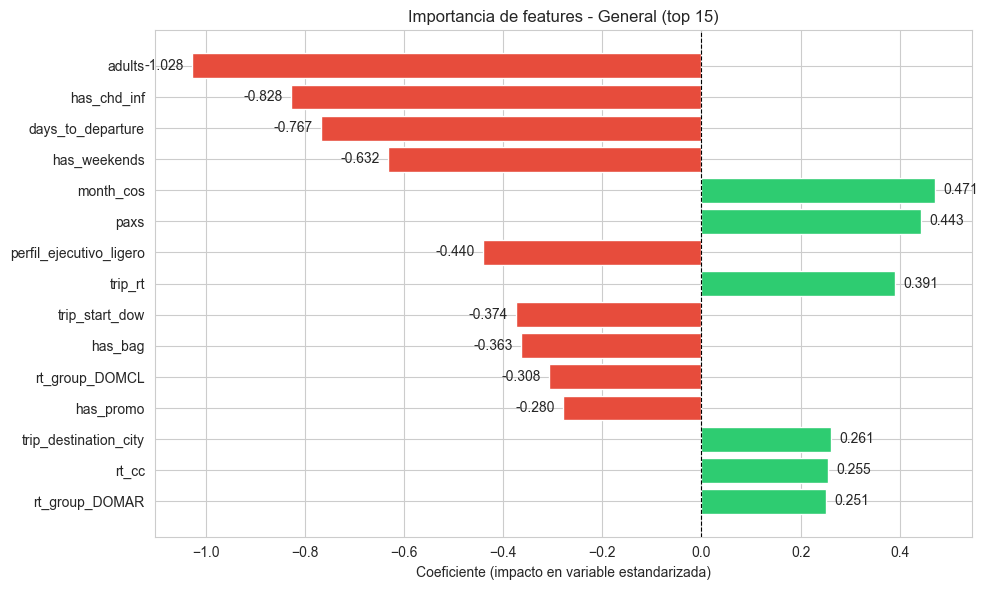

In [8]:
# --- Modelo General ---
print("Cargando datos para el Modelo General...")
X_train_gen = pd.read_parquet(f'{DATA_DIR}X_train_general_encoded.parquet')
X_test_gen = pd.read_parquet(f'{DATA_DIR}X_test_general_encoded.parquet')
y_train_gen = pd.read_pickle(f'{DATA_DIR}y_train_general.pkl')
y_test_gen = pd.read_pickle(f'{DATA_DIR}y_test_general.pkl')

modelo_general, metrics_general = entrenar_modelo_visual(
    X_train_gen, X_test_gen, y_train_gen, y_test_gen, "General", PARAMS_LR_GENERAL
)


Cargando datos para el Modelo Chile...
 PROCESANDO MODELO: CL
-> Aplicando SMOTE en CL...
-> Entrenando Regresión Logística (con Escalado estándar)...

--- RESULTADOS: CL ---
ROC-AUC: 0.8366
              precision    recall  f1-score   support

    Ocio (0)       0.87      0.73      0.79       596
 Trabajo (1)       0.61      0.80      0.69       317

    accuracy                           0.75       913
   macro avg       0.74      0.76      0.74       913
weighted avg       0.78      0.75      0.76       913



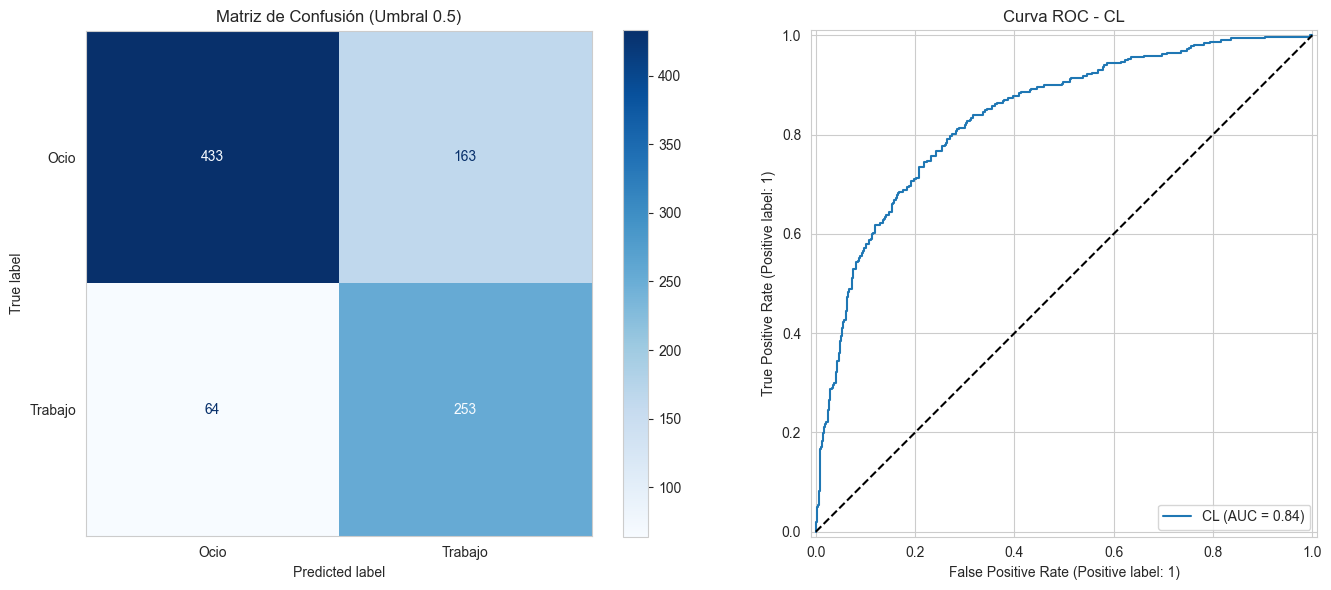

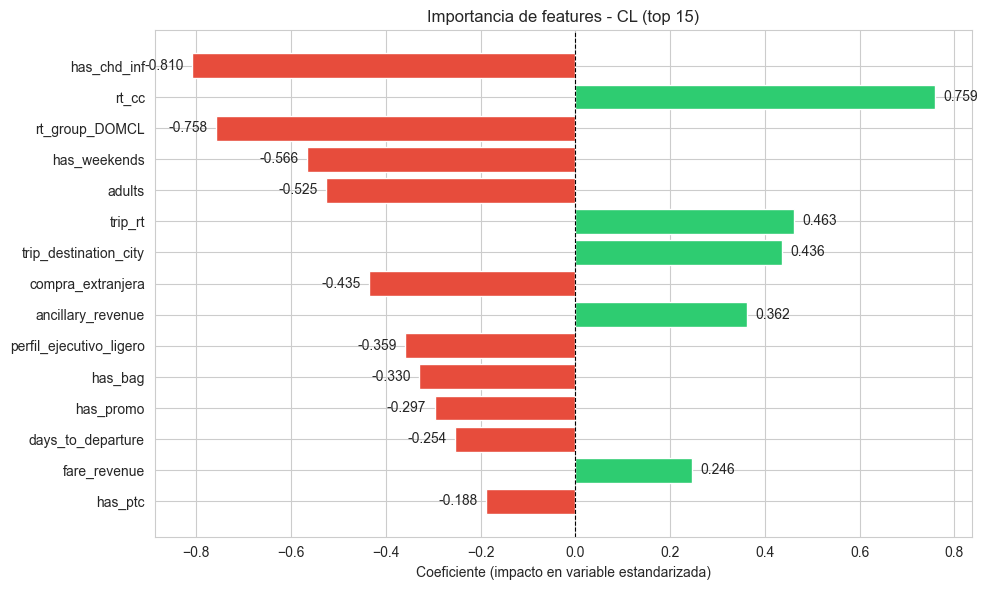

In [9]:
# --- Modelo Chile ---
print("Cargando datos para el Modelo Chile...")
X_train_CL = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOCL}_encoded.parquet')
X_test_CL = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOCL}_encoded.parquet')
y_train_CL = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOCL}.pkl')
y_test_CL = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOCL}.pkl')

modelo_chile, metrics_chile = entrenar_modelo_visual(
    X_train_CL, X_test_CL, y_train_CL, y_test_CL, MODELOCL, PARAMS_LR_CHILE
)


In [10]:
# # --- Modelo Inter ---
# print("Cargando datos para el Modelo Chile...")
# X_train_IN = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOIN}_encoded.parquet')
# X_test_IN = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOIN}_encoded.parquet')
# y_train_IN = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOIN}.pkl')
# y_test_IN = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOIN}.pkl')
#
# modelo_chile, metrics_chile = entrenar_modelo_visual(
#     X_train_IN, X_test_IN, y_train_IN, y_test_IN, MODELOIN, PARAMS_LR_GENERAL)

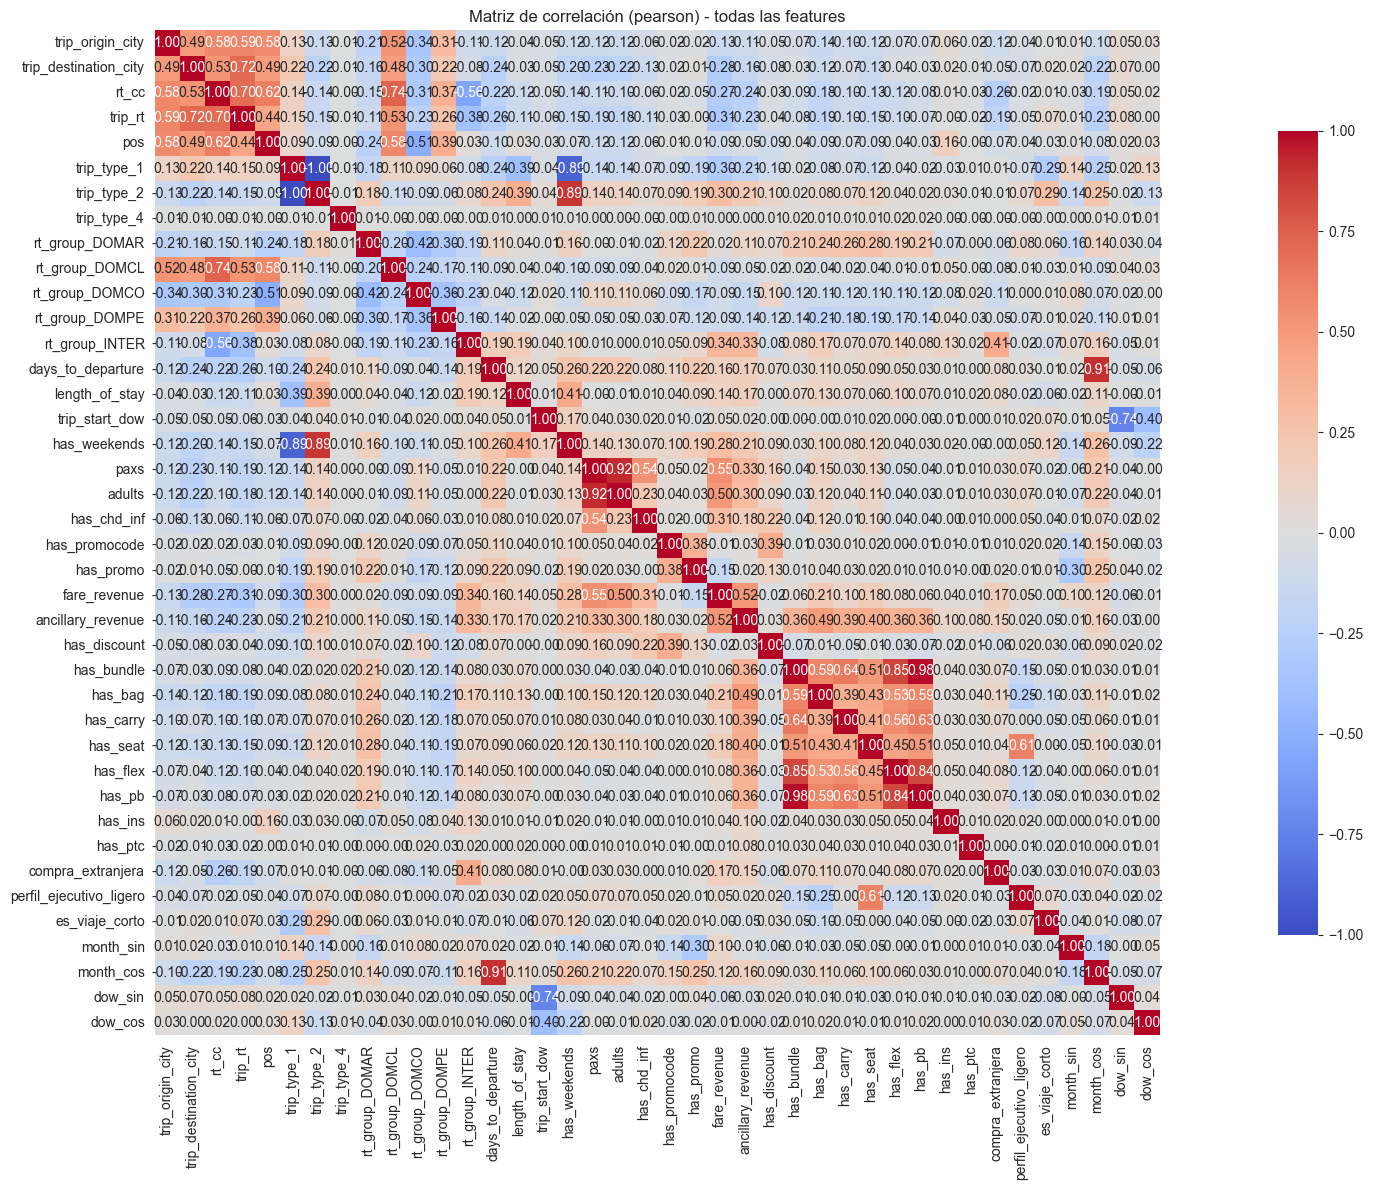

,trip_origin_city,trip_destination_city,rt_cc,trip_rt,pos,trip_type_1,trip_type_2,trip_type_4,rt_group_DOMAR,rt_group_DOMCL,rt_group_DOMCO,rt_group_DOMPE,rt_group_INTER,days_to_departure,length_of_stay,trip_start_dow,has_weekends,paxs,adults,has_chd_inf,has_promocode,has_promo,fare_revenue,ancillary_revenue,has_discount,has_bundle,has_bag,has_carry,has_seat,has_flex,has_pb,has_ins,has_ptc,compra_extranjera,perfil_ejecutivo_ligero,es_viaje_corto,month_sin,month_cos,dow_sin,dow_cos
trip_origin_city,1.000000,0.492695,0.582705,0.590402,0.577408,0.128712,-0.128636,-0.005849,-0.214407,0.523482,-0.337118,0.308345,-0.108893,-0.119168,-0.039271,-0.051014,-0.117632,-0.121537,-0.116566,-0.063973,-0.017280,-0.018548,-0.130587,-0.105669,-0.050720,-0.069810,-0.136736,-0.095685,-0.116606,-0.074913,-0.065745,0.056423,-0.019727,-0.115170,-0.035779,-0.007268,0.010785,-0.100965,0.052072,0.026747
trip_destination_city,0.492695,1.000000,0.529607,0.718329,0.485065,0.219315,-0.219207,-0.008398,-0.162713,0.478549,-0.299567,0.219508,-0.077152,-0.243650,-0.031706,-0.051612,-0.200447,-0.234530,-0.221058,-0.130209,-0.019673,0.010890,-0.279256,-0.155548,-0.077527,-0.030372,-0.122104,-0.069051,-0.129731,-0.037680,-0.026466,0.018087,-0.010751,-0.048959,-0.065688,0.016166,0.018043,-0.221046,0.065515,0.000298
rt_cc,0.582705,0.529607,1.000000,0.699566,0.618509,0.140822,-0.140801,-0.001638,-0.151270,0.738017,-0.307907,0.370199,-0.561788,-0.223034,-0.124267,-0.048309,-0.135000,-0.109577,-0.104373,-0.057901,-0.020342,-0.049869,-0.273283,-0.241395,-0.034276,-0.085101,-0.182447,-0.104485,-0.125177,-0.122381,-0.081061,0.009796,-0.025171,-0.256148,-0.023774,0.006135,-0.030617,-0.190136,0.054582,0.021165
trip_rt,0.590402,0.718329,0.699566,1.000000,0.443529,0.148299,-0.148203,-0.007458,-0.108425,0.527128,-0.225459,0.256063,-0.380168,-0.261752,-0.112845,-0.064291,-0.150800,-0.190718,-0.177766,-0.113327,-0.031942,-0.003464,-0.306752,-0.226519,-0.035361,-0.078791,-0.194623,-0.103315,-0.148383,-0.101792,-0.074041,-0.003386,-0.016731,-0.194733,-0.045186,0.065914,0.007790,-0.234569,0.076998,0.003596
pos,0.577408,0.485065,0.618509,0.443529,1.000000,0.093903,-0.093869,-0.002606,-0.243103,0.584017,-0.509095,0.391132,0.034357,-0.102312,0.025241,-0.031985,-0.071148,-0.124619,-0.124091,-0.057076,-0.005628,-0.012950,-0.087909,-0.050953,-0.094337,-0.037475,-0.093058,-0.070493,-0.087064,-0.038994,-0.032725,0.163482,-0.004431,-0.072227,-0.038233,-0.033840,0.005093,-0.079969,0.021467,0.032166
trip_type_1,0.128712,0.219315,0.140822,0.148299,0.093903,1.000000,-0.999918,-0.006167,-0.179027,0.113965,0.092771,0.058929,-0.082547,-0.239552,-0.389069,-0.043352,-0.892461,-0.141857,-0.137550,-0.068721,-0.094280,-0.185605,-0.295817,-0.206694,-0.100187,-0.024314,-0.081722,-0.074342,-0.123025,-0.041598,-0.023320,-0.026268,0.005611,0.006867,-0.074237,-0.285823,0.143221,-0.245635,0.021180,0.128586
trip_type_2,-0.128636,-0.219207,-0.140801,-0.148203,-0.093869,-0.999918,1.000000,-0.006655,0.178887,-0.113937,-0.092712,-0.058887,0.082574,0.239411,0.389028,0.043220,0.892369,0.141839,0.137514,0.068753,0.094302,0.185489,0.295788,0.206675,0.100054,0.024077,0.081581,0.074189,0.122905,0.041397,0.023088,0.026279,-0.005605,-0.006847,0.074272,0.285846,-0.143242,0.245450,-0.021086,-0.128669
trip_type_4,-0.005849,-0.008398,-0.001638,-0.007458,-0.002606,-0.006167,-0.006655,1.000000,0.010827,-0.002194,-0.004559,-0.003258,-0.002065,0.010927,0.003101,0.010277,0.006910,0.001424,0.002752,-0.002547,-0.001736,0.009032,0.002190,0.001418,0.010346,0.018409,0.010991,0.011868,0.009351,0.015692,0.018039,-0.000809,-0.000471,-0.001547,-0.002720,-0.001902,0.001676,0.014438,-0.007356,0.006523
rt_group_DOMAR,-0.214407,-0.162713,-0.151270,-0.108425,-0.243103,-0.179027,0.178887,0.010827,1.000000,-0.202634,-0.421133,-0.300889,-0.190692,0.106863,0.044622,-0.014506,0.155733,-0.004386,-0.005978,-0.015649,0.116714,0.219475,0.020298,0.112896,0.066230,0.212799,0.239227,0.260780,0.275848,0.192991,0.209998,-0.072424,0.000031,-0.056758,0.079827,

In [11]:
matriz_correlacion_por_modelo(modelo_general, X_train_gen)
